# Text Similarity with Quora question pair
## 1. Data load

### zipfile

In [1]:
import zipfile 

FILE_PATH = "C:/python/NLP/Chap_5/"
FILE_NAME = ['quora-question-pairs.zip']

for file in FILE_NAME:
    zipRef = zipfile.ZipFile(FILE_PATH + file, 'r')
    zipRef.extractall(FILE_PATH)
    zipRef.close()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

In [3]:
train_data = pd.read_csv(FILE_PATH + 'train.csv', header=0)
print("Train data: ")
print("Number of train data: ", train_data.info())
train_data.head()

Train data: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB
Number of train data:  None


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## 2. EDA

* Data size
* Number of data
* Distribution of duplicate question
* Most used word
* neg & pos distribution
* Distribution of number of each word
* Ratio of capital, small letter and special character

### 2.1 Data size

In [4]:
import os
import re
import time

In [10]:
for file in os.listdir(FILE_PATH):
    if 'csv' in file and 'zip' not in file:
        print(file.ljust(30) + str(round(os.path.getsize(FILE_PATH + file) / 1000000, 2)) + 'MB')

sample_submission.csv         22.35MB
test.csv                      314.02MB
train.csv                     63.4MB


In [11]:
os.listdir(FILE_PATH)

['quora-question-pairs.zip', 'sample_submission.csv', 'test.csv', 'train.csv']

### 2.2 Number of train data

In [12]:
print("Number of train data: {}.".format(len(train_data)))

Number of train data: 404290.


In [13]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### 2.3 Distribution of duplicate question

##### Combine two questions

Append it to below

In [44]:
train_set = pd.Series(train_data['question1'].tolist() + train_data['question2'].tolist()).astype(str)
train_set.head()

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
dtype: object

In [45]:
print("Number of all data: {}".format(len(train_data)))
print("Number of unique data: {}".format(len(np.unique(train_set)))) # np.unique
print("Number of duplication: {}".format(np.sum(train_set.value_counts() > 1)))

Number of all data: 404290
Number of unique data: 537361
Number of duplication: 111873


##### value_counts() returns result as Series

Text(0.5, 1.0, 'log-scale Histogram')

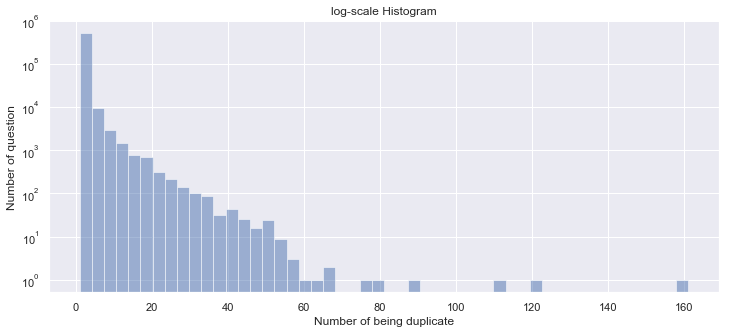

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.hist(train_set.value_counts(), bins=50, alpha=0.5)
plt.yscale('log', nonposy='clip')
plt.xlabel("Number of being duplicate")
plt.ylabel("Number of question")
plt.title("log-scale Histogram")

### 2.4 Other statistics & Box plot


In [14]:
print("Max: {}".format(np.max(train_set.value_counts())))
print("Min: {}".format(np.min(train_set.value_counts())))
print("Mean: {:.2f}".format(np.mean(train_set.value_counts())))
print("Median: {}".format(np.median(train_set.value_counts())))
print("Std: {:.2f}".format(np.std(train_set.value_counts())))
print("1st quantile: {}".format(np.percentile(train_set.value_counts(), 25)))
print("3rd quantile: {}".format(np.percentile(train_set.value_counts(), 75)))

Max: 161
Min: 1
Mean: 1.50
Median: 1.0
Std: 1.91
1st quantile: 1.0
3rd quantile: 1.0


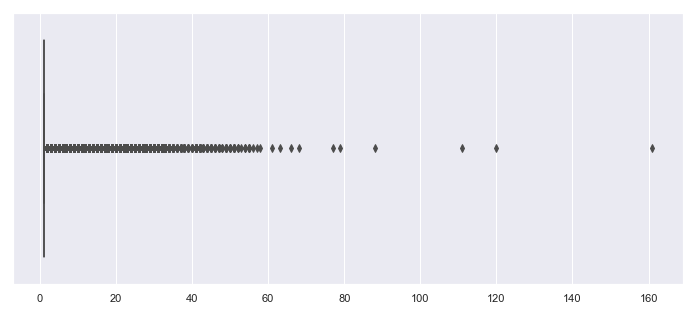

In [15]:
plt.figure(figsize=(12,5))
sns.boxplot(train_set.value_counts())

### 2.5 Most used word

(-0.5, 799.5, 599.5, -0.5)

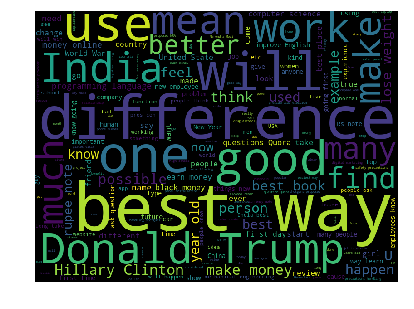

In [16]:
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600).generate(" ".join(train_set.astype(str)))
plt.figure(figsize=(20, 5))
plt.imshow(cloud)
plt.axis('off')

### 2.6 Duplicate or Not

In [17]:
train_data['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

Text(0, 0.5, 'Number')

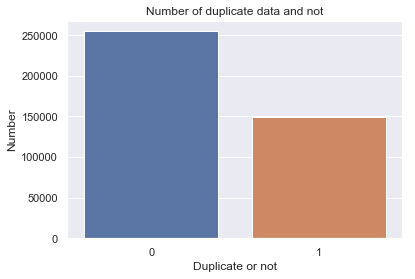

In [18]:
sns.countplot(data=train_data,  x='is_duplicate')
plt.title("Number of duplicate data and not")
plt.xlabel("Duplicate or not")
plt.ylabel("Number")

### 2.7 Distribution of number of words

In [20]:
train_set.head()

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
dtype: object

In [21]:
num_words = train_set.apply(lambda x: len(x.split(" ")))

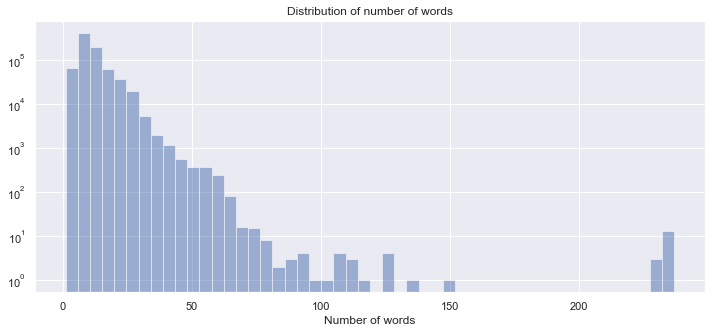

In [32]:
plt.figure(figsize=(12, 5))
plt.hist(num_words, bins=50, alpha=0.5)
plt.xlabel("Number of words")
plt.yscale("log", nonposy='clip')
plt.title("Distribution of number of words")
plt.show()

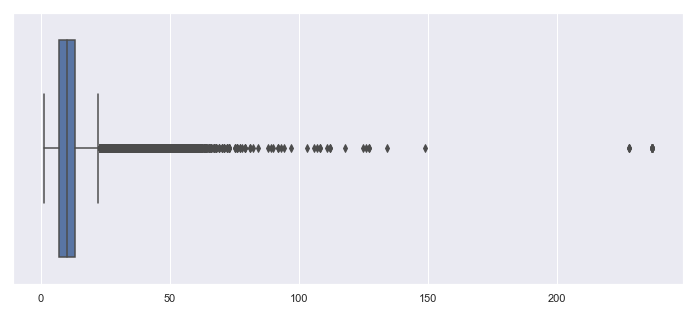

In [35]:
plt.figure(figsize=(12, 5))
sns.boxplot(num_words)

In [41]:
print("Max: {}".format(np.max(num_words)))
print("Min: {}".format(np.min(num_words)))
print("Mean: {:.2f}".format(np.mean(num_words)))
print("Median: {}".format(np.median(num_words)))
print("Std: {:.2f}".format(np.std(num_words)))
print("1st quantile: {}".format(np.percentile(num_words, 25)))
print("3rd quantile: {}".format(np.percentile(num_words, 75)))

Max: 237
Min: 1
Mean: 11.06
Median: 10.0
Std: 5.89
1st quantile: 7.0
3rd quantile: 13.0


### 2.8 Ratio of capital or small or others

In [43]:
train_set.apply(lambda x: '?' in x).head()

0    True
1    True
2    True
3    True
4    True
dtype: bool

In [44]:
np.mean(train_set.apply(lambda x: '?' in x))

0.9987385292735412

In [47]:
fullstop = print("Fullstop mark: {:2f}%".format(np.mean(train_set.apply(lambda x: '.' in x))*100))
qmard = print("Question mark: {:2f}%".format(np.mean(train_set.apply(lambda x: '?' in x))*100))
capital_first = print("Capital letter first: {:2f}%".format(np.mean(train_set.apply(lambda x: x[0].isupper()))*100))

capitals = print("Capital letters: {:2f}%".format(np.mean(train_set.apply(lambda x: max([y.isupper() for y in x])))*100))
numbers = print("Number: {:2f}%".format(np.mean(train_set.apply(lambda x: max([y.isdigit() for y in x])))*100))


Fullstop mark: 6.308219%
Question mark: 99.873853%
Capital letter first: 99.813253%
Capital letters: 99.950531%
Number: 11.827154%


### Nan in question1

In [10]:
for data in train_data['question1']:
    if type(data) is not str:
        print(data)

nan


null 값이 존재해서 숫자만을 추출할 수 없었음.

null 값 가지고 있는 모든 행 삭제

In [11]:
train_data = train_data.dropna()

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
id              404287 non-null int64
qid1            404287 non-null int64
qid2            404287 non-null int64
question1       404287 non-null object
question2       404287 non-null object
is_duplicate    404287 non-null int64
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [13]:
for data in train_data['question1']:
    if type(data) is not str:
        print(data)

null 행 삭제 후 확인

.apply(len) 방법으로 *Series*로 받는 방법과 for 문 *list*로 받는 방법 두가지

In [14]:
start_time = time.time()

train_length = train_data['question1'].apply(len)
train_length.head()

end_time = time.time()
fin = end_time - start_time
print(fin)

0.17012810707092285


In [15]:
start_time = time.time()

length_1 = []
for data in train_data['question1']:
    length_1.append(len(data))

end_time = time.time()
fin = end_time - start_time
print(fin)

0.17310285568237305
